In [1]:
import nicepy as npy
from IPython.display import display, HTML
import sklearn as sk
from sklearn import tree, neighbors, model_selection
import graphviz

%matplotlib inline

# 1)

In [2]:
class decision_tree:
    parameters = ['HasOutdoorSeating', 'HasBar', 'IsClean', 'HasGoodAtmosphere']
    is_good = 'IsGoodRestaurant'
    
    def __init__(self, df):
        self.df = df
        self._get_training_data()
        self._get_testing_data()
        self.h_is_good = self.get_entropy(self.train, 'IsGoodRestaurant')
        
    def _get_training_data(self):
        self.train = self.df.dropna()
        
    def _get_testing_data(self):
        self.test = self.df[self.df.isna().any(axis=1)]
    
    @staticmethod
    def entropy(p):
        """
        Finds:
        
        H(p) = -p log(p) - (1-p) log(1-p)
        """
        if p in [0,1]:
            output = 0
        else:
            output = -p*np.log2(p)-(1-p)*np.log2(1-p)

        return output
    
    @staticmethod
    def get_probability(df, event):
        """
        Finds:
        
        P(event)
        
        within data set (df)
        """
        
        output = df[event].mean()
        
        return output
    
    def get_IG(self, df, condition, event=is_good):
        """
        Finds:
        
        IG = H(P(event)) - H(event|condition)
        
        within data set (df)
        """
        
        h_event = self.get_entropy(df, event)
        
        h_condition = self.get_conditional_entropy(df, condition, event)
        
        output = h_event - h_condition
        
        return output
        
    
    def get_entropy(self, df, event):
        """
        Finds:
        
        H(P(event))
        
        within data set (df)
        """
        
        p = self.get_probability(df, event)
        
        output = self.entropy(p)
        
        return output

    def get_subset(self, df, condition, truth):
        """
        Returns subset of data set df given condition == truth
        """
        truth = truth * 1
        
        output = df[df[condition] == truth]
        
        return output
    
    def get_conditional_entropy(self, df, condition, event=is_good):
        """
        Finds:
        
        sum(H(event|condition=i)P(condition=i)), i=[0,1]
        
        within data set (df)
        """
        output = 0
        
        p_cond = self.get_probability(df, condition)
        
        for truth in [0,1]:
            df_subset = self.get_subset(df, condition, truth)
            
            h_event_subset = self.get_entropy(df_subset, event)

            output += h_event_subset * abs(1-truth-p_cond)
        
        return output
    
    def get_all_H(self, df, event=is_good):
        d = {}
        for parameter in self.parameters:
            s = 'H(%s|%s)' %(event, parameter)
            d[s] = self.get_conditional_entropy(df, parameter, event)
        
        output = pd.Series(d)
        
        return output
    
    def get_all_IG(self, df, event=is_good):
        d = {}
        for parameter in self.parameters:
            s = 'IG(%s|%s)' %(event, parameter)
            d[s] = self.get_IG(df, parameter, event)
        
        output = pd.Series(d)
        
        return output

In [3]:
seating = [0, 1, 0, 0, 1, 1, 1, 0, 0, 1]
bar = [0, 0, 1, 0, 1, 0, 0, 0, 1, 1]
clean = [1, 0, 1, 0, 0, 1, 0, 1, 0, 1]
atmosphere = [1, 0, 1, 0, 0, 0, 1, 1, 1 ,1]
good = [1, 0, 1, 0, 0, 1, 1, 1]
table = [seating, bar, clean, atmosphere, good]

df = pd.DataFrame(table).transpose()
df.columns = ['HasOutdoorSeating', 'HasBar', 'IsClean', 'HasGoodAtmosphere', 'IsGoodRestaurant']
train = df.dropna()
test = df[df.isna().any(axis=1)]
train

,HasOutdoorSeating,HasBar,IsClean,HasGoodAtmosphere,IsGoodRestaurant
0,0.0,0.0,1.0,1.0,1.0
1,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,1.0,1.0
3,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,0.0,0.0,0.0
5,1.0,0.0,1.0,0.0,1.0
6,1.0,0.0,0.0,1.0,1.0
7,0.0,0.0,1.0,1.0,1.0


In [4]:
dt = decision_tree(df)

## a) What is $H(IsGoodRestaurant)$?

In [5]:
dt.get_probability(dt.train, dt.is_good)

0.625

In [6]:
dt.get_entropy(dt.train, event=dt.is_good)

0.954434002924965

## b) What is $H(IsGoodRestaurant|HasOutdoorSeating)$?

In [7]:
dt.get_conditional_entropy(dt.train, 'HasOutdoorSeating', event=dt.is_good)

0.9056390622295665

## c) What is $H(IsGoodRestaurant|X)$, for $X\in \{HasBar, IsClean, HasGoodAtmosphere\}$?

In [8]:
display(dt.get_all_H(dt.train, dt.is_good))

H(IsGoodRestaurant|HasOutdoorSeating)    0.905639
H(IsGoodRestaurant|HasBar)               0.938722
H(IsGoodRestaurant|IsClean)              0.405639
H(IsGoodRestaurant|HasGoodAtmosphere)    0.405639
dtype: float64

## d) Calculate the information gain

In [9]:
display(dt.get_all_IG(dt.train, dt.is_good))

IG(IsGoodRestaurant|HasOutdoorSeating)    0.048795
IG(IsGoodRestaurant|HasBar)               0.015712
IG(IsGoodRestaurant|IsClean)              0.548795
IG(IsGoodRestaurant|HasGoodAtmosphere)    0.548795
dtype: float64

In [10]:
print('IsClean')
for truth in [0, 1]:
    print('truth = %i' %truth)
    subset = dt.get_subset(dt.train, 'IsClean', truth=truth)
    display(dt.get_all_H(subset, dt.is_good))

IsClean
truth = 0


H(IsGoodRestaurant|HasOutdoorSeating)    0.688722
H(IsGoodRestaurant|HasBar)               0.688722
H(IsGoodRestaurant|IsClean)                   NaN
H(IsGoodRestaurant|HasGoodAtmosphere)    0.000000
dtype: float64

truth = 1


H(IsGoodRestaurant|HasOutdoorSeating)    0.0
H(IsGoodRestaurant|HasBar)               0.0
H(IsGoodRestaurant|IsClean)              NaN
H(IsGoodRestaurant|HasGoodAtmosphere)    0.0
dtype: float64

In [11]:
print('HasGoodAtmosphere')
for truth in [0, 1]:
    print('truth = %i' %truth)
    subset = dt.get_subset(dt.get_subset(dt.train, 'IsClean', truth=0), 'HasGoodAtmosphere', truth=truth)
    display(dt.get_all_H(subset, dt.is_good))

HasGoodAtmosphere
truth = 0


H(IsGoodRestaurant|HasOutdoorSeating)    0.0
H(IsGoodRestaurant|HasBar)               0.0
H(IsGoodRestaurant|IsClean)              NaN
H(IsGoodRestaurant|HasGoodAtmosphere)    NaN
dtype: float64

truth = 1


H(IsGoodRestaurant|HasOutdoorSeating)   NaN
H(IsGoodRestaurant|HasBar)              NaN
H(IsGoodRestaurant|IsClean)             NaN
H(IsGoodRestaurant|HasGoodAtmosphere)   NaN
dtype: float64

# 3)

\begin{align*}
    gini(q(V)) & = 2 q(V) (1- q(V)) \\
    H(q(V)) & = -q(V) \log(q(V) - (1-q(V))\log(1-q(V)))
\end{align*}

In [12]:
def gini(p):
    """
    Finds:
    
    gini = 2p(1-p)
    """
    
    output = 2*p*(1-p)
    
    return output

def entropy(p):
    """
    Finds:

    H(p) = -p log(p) - (1-p) log(1-p)
    """
    if p in [0,1]:
        output = 0
    else:
        output = -p*np.log2(p)-(1-p)*np.log2(1-p)

    return output

## a)

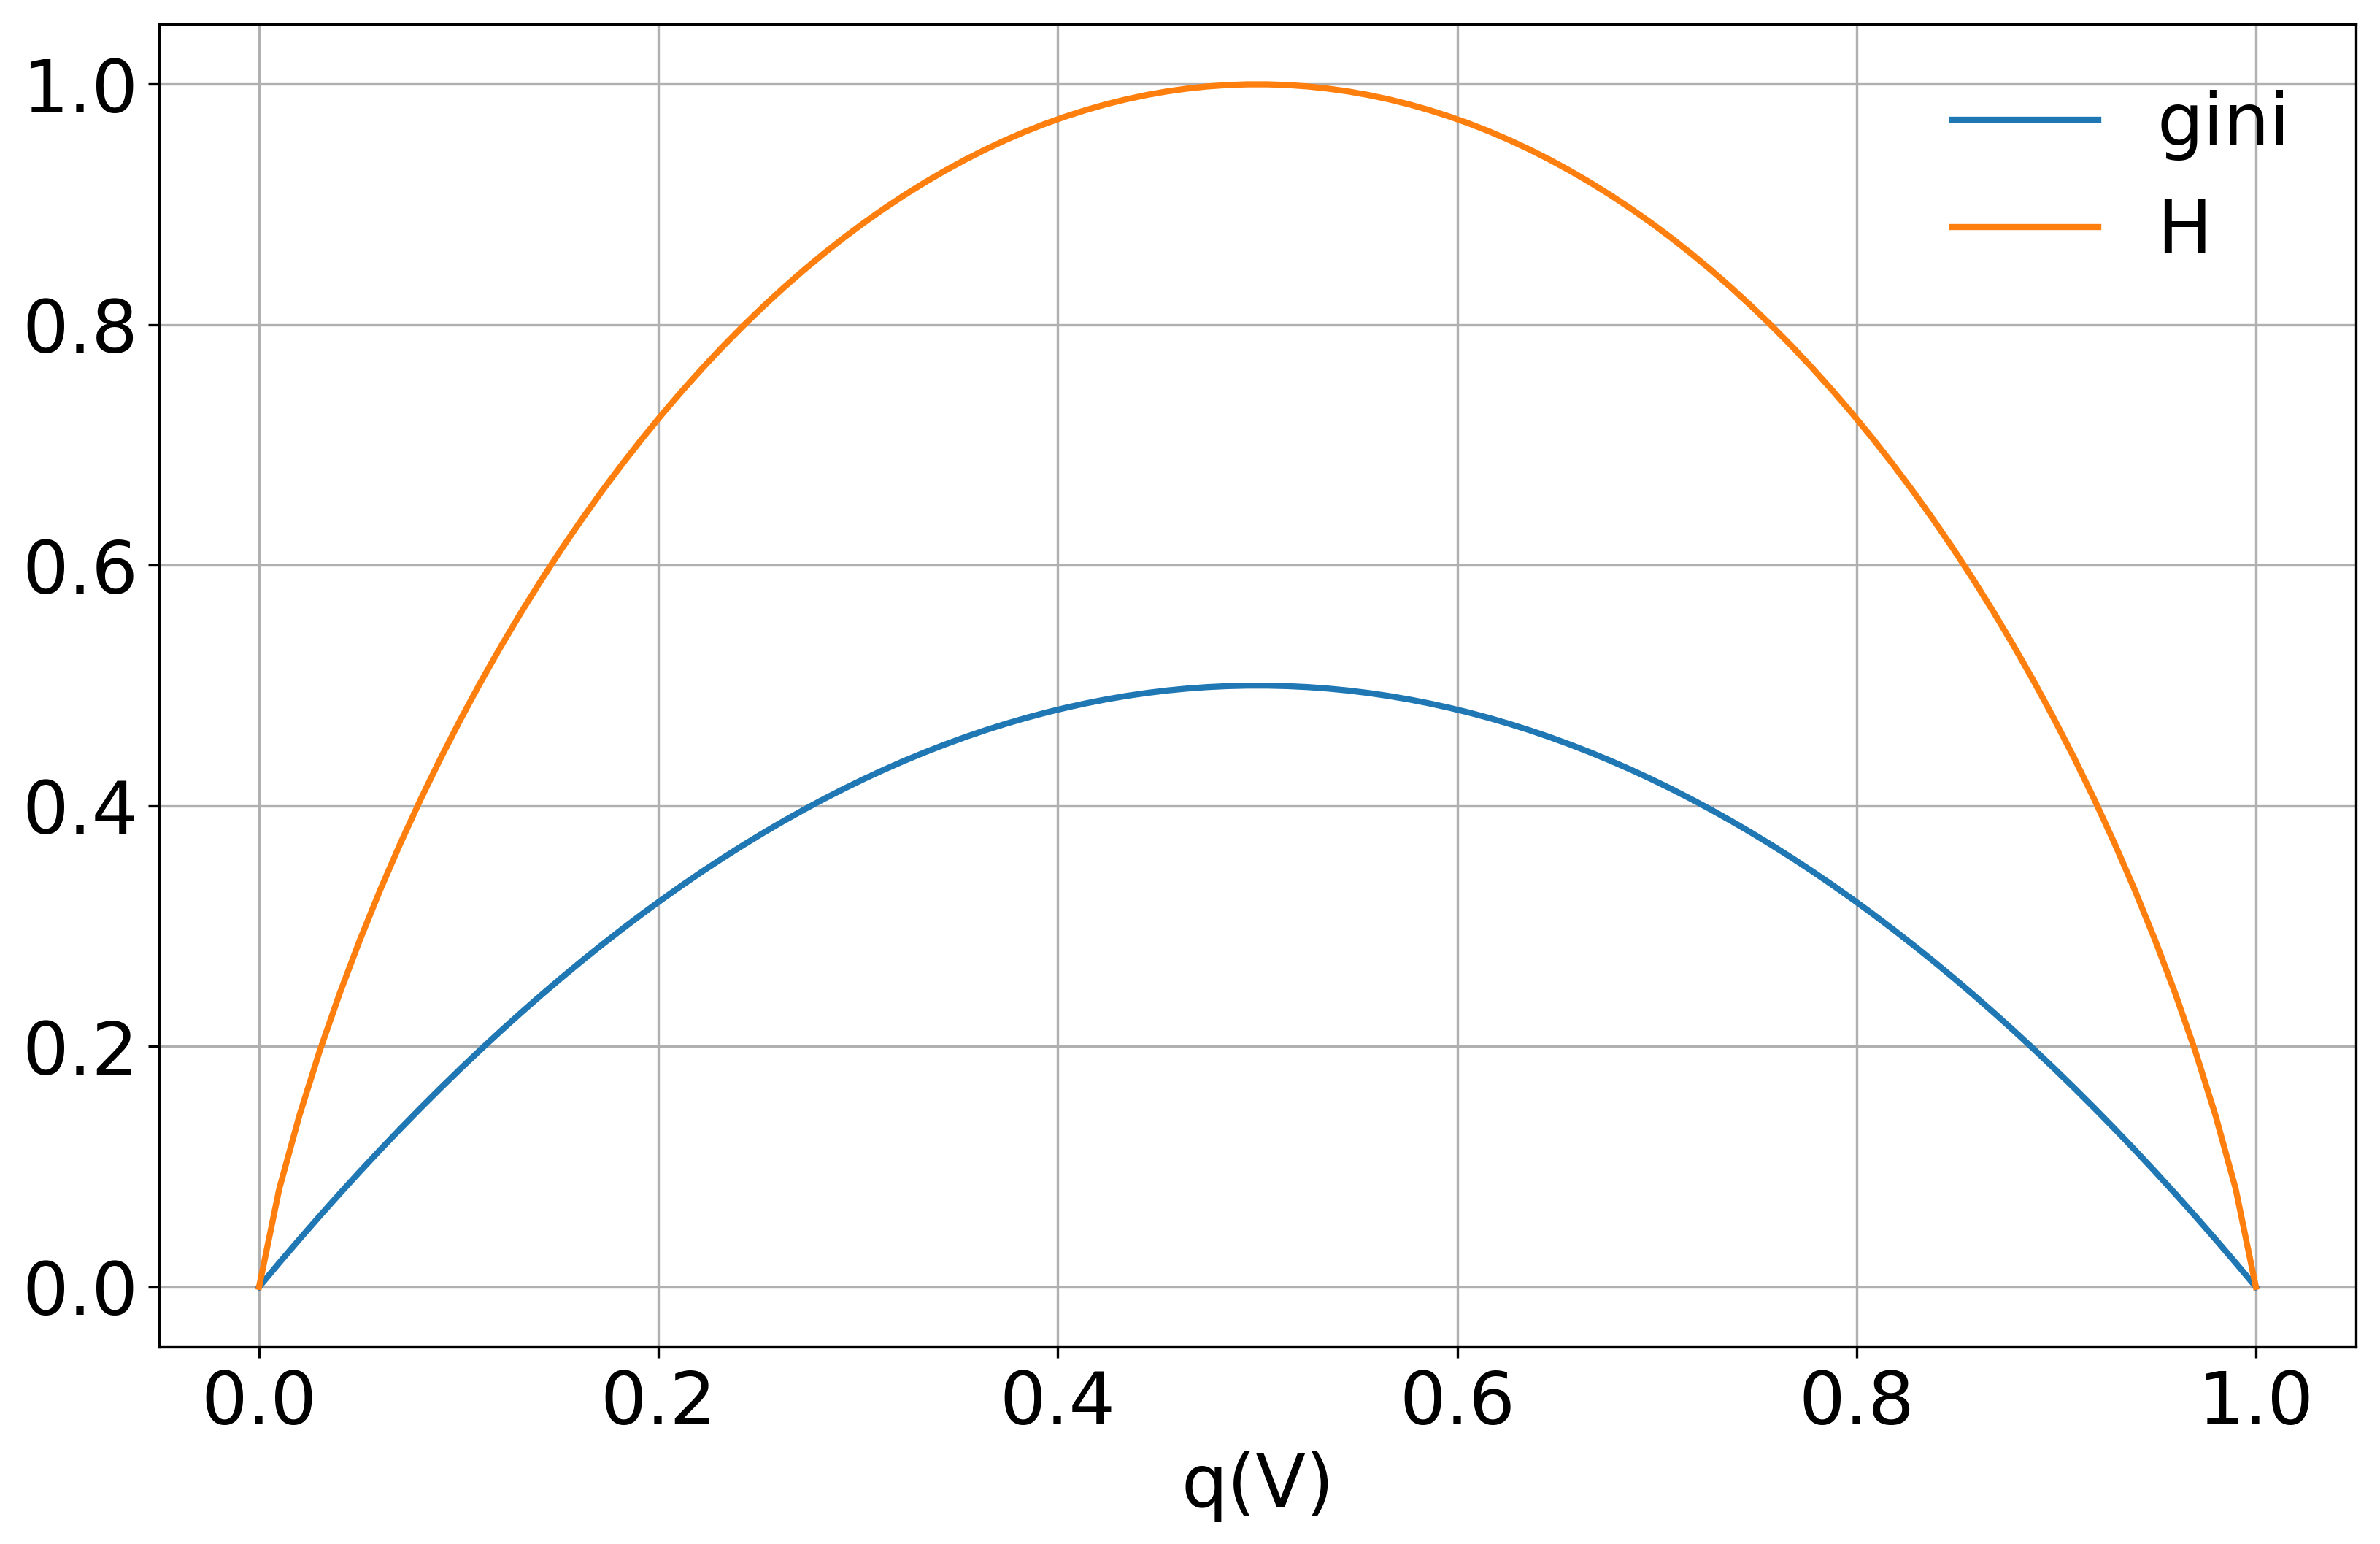

In [13]:
q_V = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
ax.plot(q_V, gini(q_V), label='gini')
ax.plot(q_V, [entropy(p) for p in q_V], label='H')

ax.set_xlabel('q(V)')
npy.format_fig(fig)
npy.format_ax(ax)
ax.grid()

fig.savefig('gini_vs_H.png', bbox_inches='tight')


# 6)

## a)

In [14]:
titanic = pd.read_csv('titanic.csv')
test_columns = titanic.columns.delete(0)
x_train = np.loadtxt('dataTraining_X.csv', delimiter=',')
x_test = np.loadtxt('dataTesting_X.csv', delimiter=',')
y_train = np.loadtxt('dataTraining_Y.csv')
y_test = np.loadtxt('dataTesting_Y.csv')

## b)

In [15]:
tree = sk.tree.DecisionTreeClassifier(criterion='entropy')
tree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [16]:
print(tree.score(x_train, y_train))
print(tree.score(x_test, y_test))

0.9859154929577465
0.711864406779661


## c)

In [17]:
for k in [1, 3, 5]:
    knn = sk.neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    print('k = %i' %k)
    print('Training accuracy: %.03f' %knn.score(x_train, y_train))
    print('Testing accuracy: %.03f' %knn.score(x_test, y_test))
    print('----------------------')

k = 1
Training accuracy: 0.985
Testing accuracy: 0.729
----------------------
k = 3
Training accuracy: 0.897
Testing accuracy: 0.768
----------------------
k = 5
Training accuracy: 0.869
Testing accuracy: 0.780
----------------------


## d)

In [18]:
tree = sk.tree.DecisionTreeClassifier(criterion='entropy')
tree.fit(x_train, y_train)
print(np.mean(sk.model_selection.cross_val_score(tree, x_train, y_train, cv=10)))

0.7947188687681646


In [19]:
for k in [1,3,5]:
    knn = sk.neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    cvs = np.mean(sk.model_selection.cross_val_score(knn, x_train, y_train, cv=10))
    print('k = %i' %k)
    print(cvs)

k = 1
0.774896042924212
k = 3
0.8199524927341828
k = 5
0.8326699083389224


## e)

In [30]:
train = []
test = []
kk = []
for k in range(1, 16):
    knn = sk.neighbors.KNeighborsClassifier(n_neighbors=k)
    res = sk.model_selection.cross_validate(knn, x_train, y_train, cv=10, return_train_score=True)
    train.append(res['train_score'].mean())
    test.append(res['test_score'].mean())
    kk.append(k)
    
vals = pd.DataFrame([kk, train, test]).transpose()
vals.columns = ['k', 'validation', 'test']
vals.set_index('k', inplace=True)
display(vals)

,validation,test
k,,
1.0,0.985136,0.774896
2.0,0.895306,0.810033
3.0,0.892491,0.819952
4.0,0.871831,0.825568
5.0,0.870423,0.832670
6.0,0.863229,0.825547
7.0,0.864948,0.817036
8.0,0.851642,0.816996
9.0,0.847729,0.822651


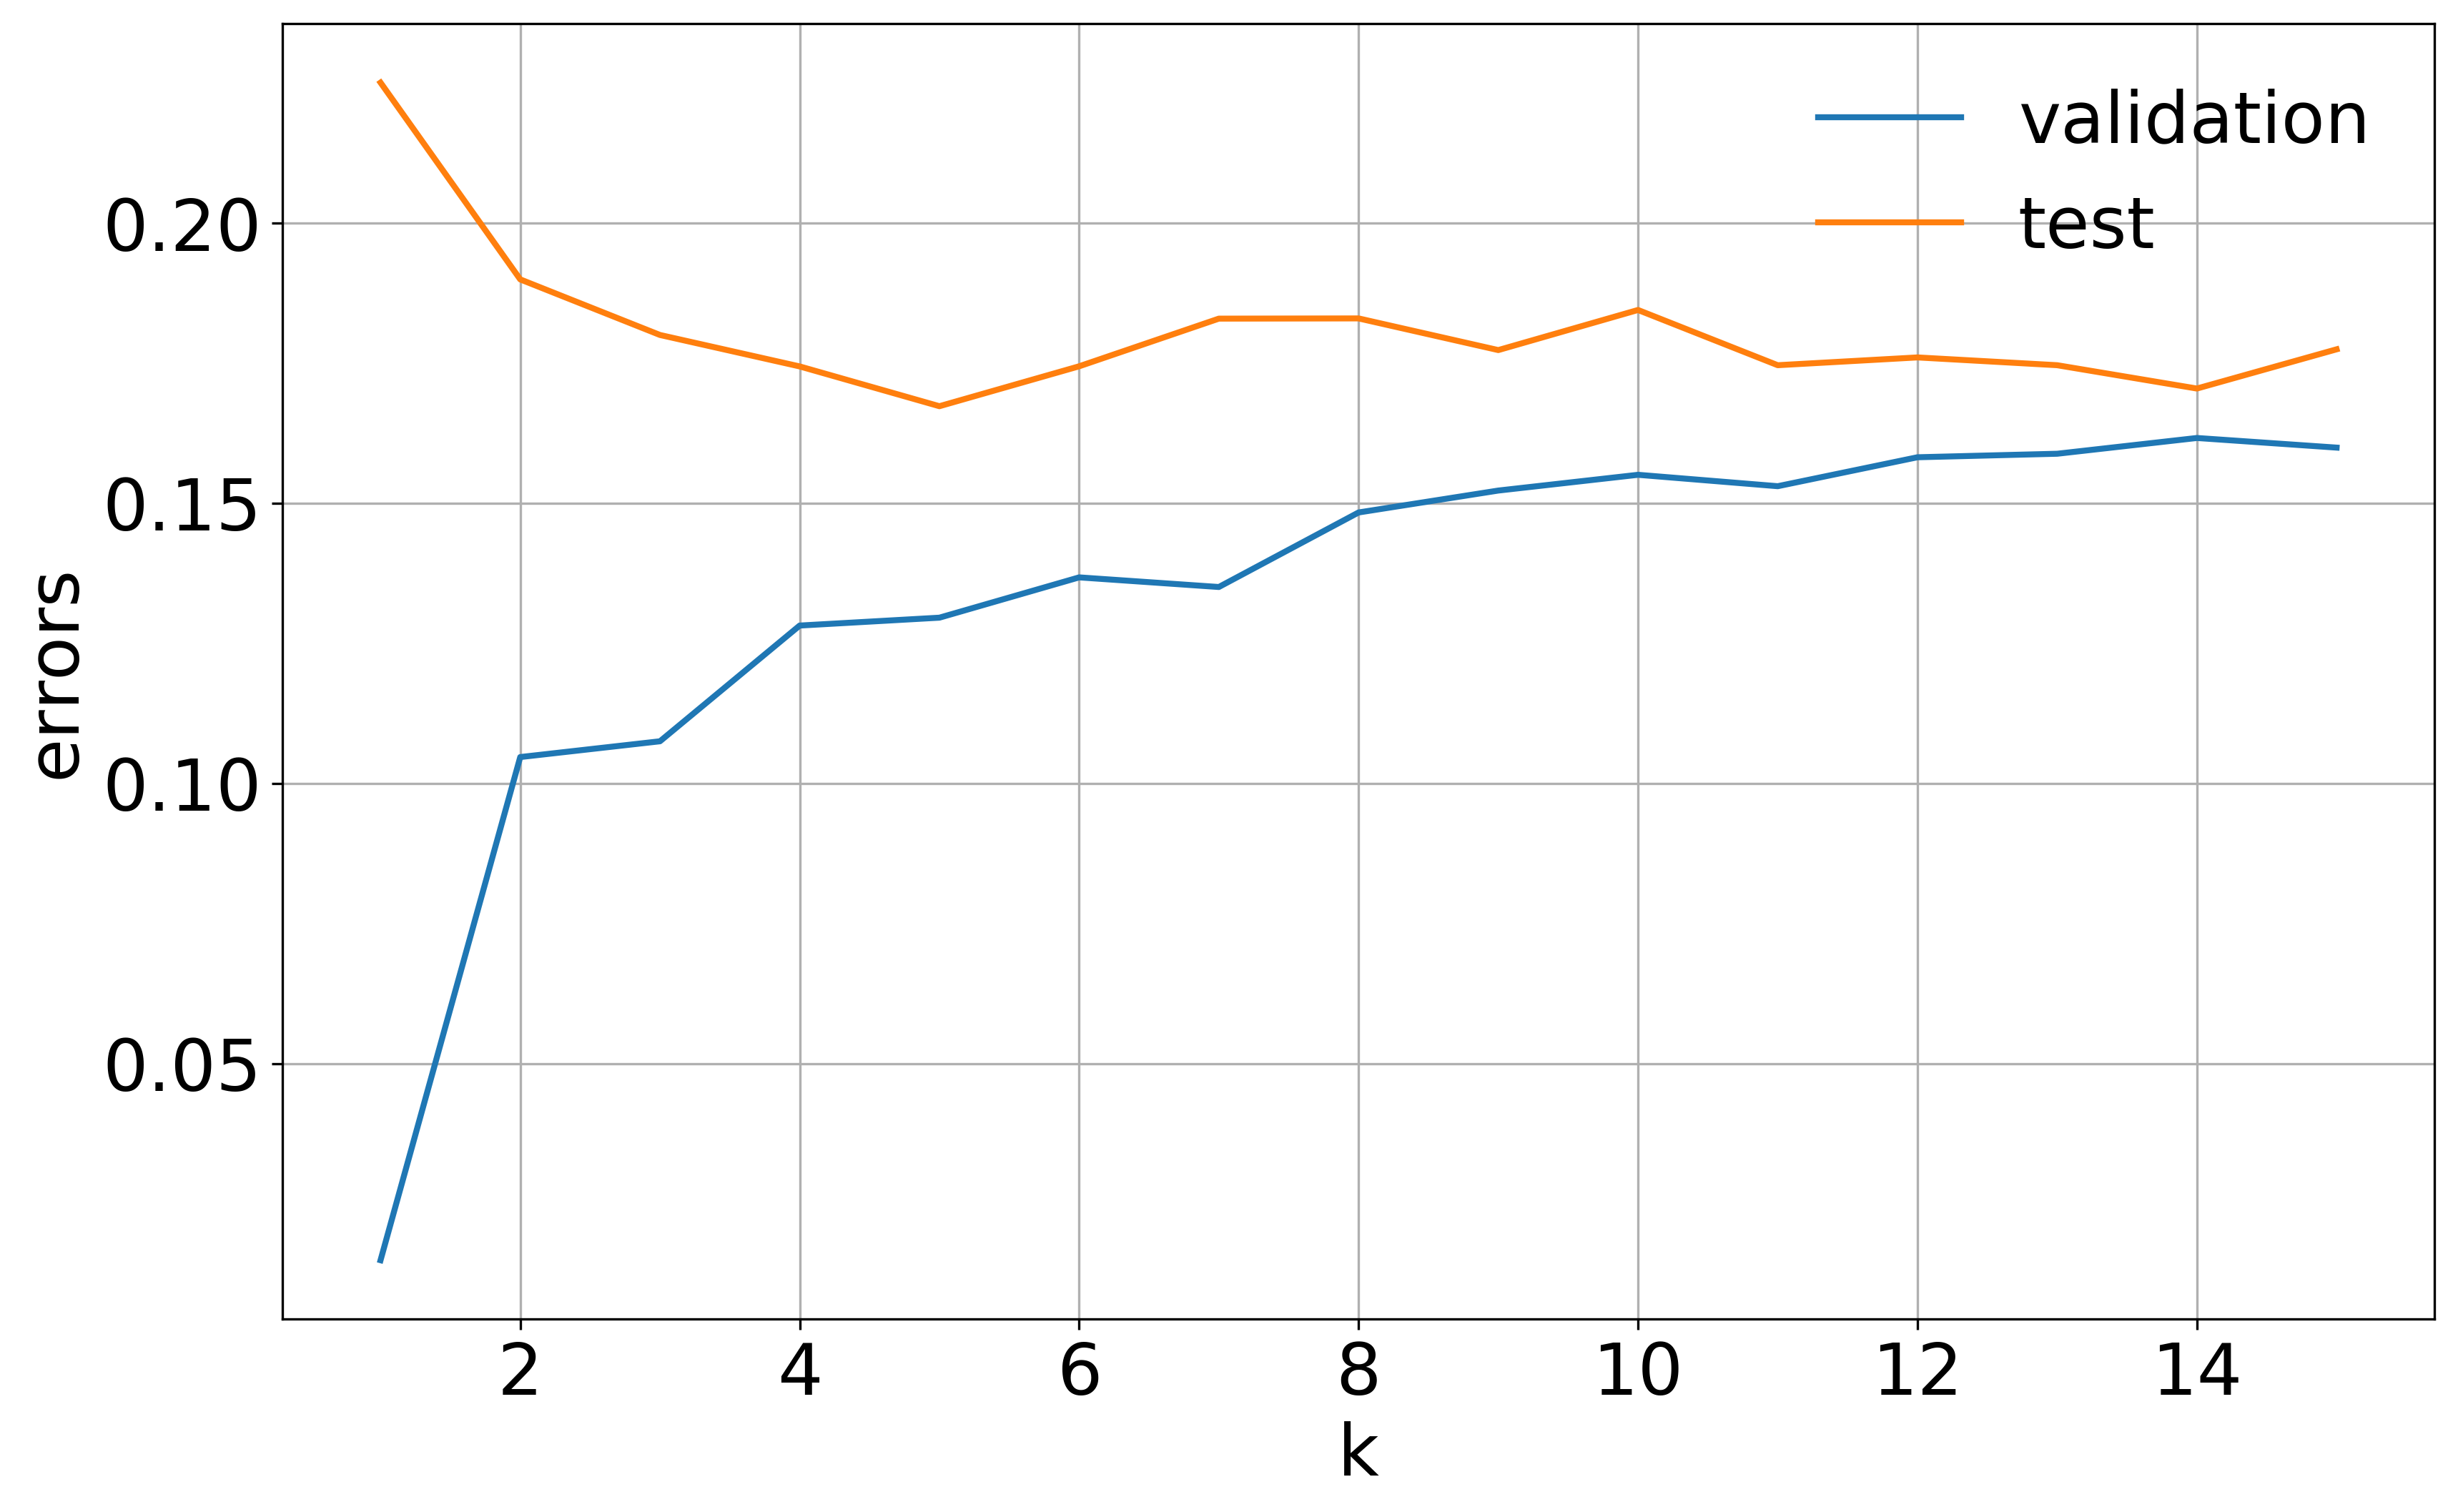

In [31]:
fig, ax = plt.subplots()
temp = 1-vals
temp.plot.line(grid=True, ax=ax)
ax.set_xlabel('k')
ax.set_ylabel('errors')

npy.format_fig(fig)
npy.format_ax(ax)

fig.savefig('errors.png', bbox_inches='tight')